# Imports and setup

This will be necessary since Tatoeba is in iso 639-3 code format

In [ ]:
!pip install python-iso639
import iso639

We want to load up our data from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# basic libraries
import os
import re
import pickle
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# model building tools
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Load data from google drive

## Flores data

### Loading Flores dataset

In [ ]:
!cp /content/drive/MyDrive/flores200_dataset.tar.gz .
!tar -xvzf flores200_dataset.tar.gz;

./flores200_dataset/
./flores200_dataset/README
./flores200_dataset/metadata_devtest.tsv
./flores200_dataset/devtest/
./flores200_dataset/devtest/glg_Latn.devtest
./flores200_dataset/devtest/swe_Latn.devtest
./flores200_dataset/devtest/war_Latn.devtest
./flores200_dataset/devtest/ltz_Latn.devtest
./flores200_dataset/devtest/lit_Latn.devtest
./flores200_dataset/devtest/tur_Latn.devtest
./flores200_dataset/devtest/bjn_Arab.devtest
./flores200_dataset/devtest/pbt_Arab.devtest
./flores200_dataset/devtest/asm_Beng.devtest
./flores200_dataset/devtest/kas_Deva.devtest
./flores200_dataset/devtest/kor_Hang.devtest
./flores200_dataset/devtest/aeb_Arab.devtest
./flores200_dataset/devtest/dan_Latn.devtest
./flores200_dataset/devtest/est_Latn.devtest
./flores200_dataset/devtest/tir_Ethi.devtest
./flores200_dataset/devtest/kin_Latn.devtest
./flores200_dataset/devtest/zsm_Latn.devtest
./flores200_dataset/devtest/ars_Arab.devtest
./flores200_dataset/devtest/cym_Latn.devtest
./flores200_dataset/devtest

In [ ]:
!head ./flores200_dataset/dev/ace_Arab.dev

يق أورو سنين، اوق علمون دري فکولتس کدوکترن يونيۏرسيتس ستانفورد ݢڤعموم اکن جتومى الت دياݢنوستيک بارو ڽڠ جوت ݢڤيليه اتو سيل منوروت جنيهجيه: چيڤ اوبيت ڽڠ جوت ݢچيتق ڽڠ جوت ݢڤݢت دڠون ڤرينتر ايڠ‌کجيت ستندر دڠون يوم موڠکين نا سابوه سين ا.س. لم تيڤ سابوه.
ڤنليتي اوتام خن اترا ڽو موڠکين محسى ديتيکسي فون کى کنکر، ت.ب.س.، ايچ.اي.ۏي. ڠون مالاريا کى ڤاسيان دي نڠرو ڽڠ ݢاسين، ڽڠ توه تيڠکت کى اودڤ کى ڤڽاکيت لاݢى کنکر بوه دادا جوت ستڠوه دري نڠرو ڽڠ لوبيه کاي.
جاس ۳۹سي ݢريڤين مڤوق لندسن ڤاچو ليڠک ڤوه ۹:۳۰ بڠوه دي سينن (۰۲۳۰ يوتيسي) ڠوت برتويه، سمڤو ݢتوڤ بندرا کى تربڠ کومرسيال.
ڤيلوت ݢکالون ايدنتيتس سباݢو کڤالا سکوادرون ديلوکريت ڤاتاۏي.
مديا دي سينن ݢڤتهى سابوه کندراءن ڤمادم اڤوي بندرا مݢولى واتى مجاوب.
ۏيدل، ۲۸ تهون، کا مݢبوڠ ڠون بارسا لهى موسيم ڽڠ کا لوڤه، دري سيۏيلا.
ڤفون ڤينه او ايبوکوتا کاتالن، ۏيدل کا ماءين ٤۹ ڤرتنديڠن کى کلوب ڽن.
ڤروتيه کڤفون ليڠک ڤوه ١١:٠٠ واتى دي سينن (يوتيسي+١) دي وايتهال سبرڠ ڤينتو تاموڠ ڽڠ ݢکاواي ڤوليسي او داونيڠ ستريت، لم مليݢو رسمي ڤردان منترو.
تڤت اوه لهوه ڤوه ١١:٠٠، اورڠ 

In [ ]:
from glob import glob

In [ ]:
def read_file(path):
  name = path.split('/')[-1][:3]
  try:
    i = iso639.Language.from_part3(name).name
  except iso639.LanguageNotFoundError:
    print('ignoring: ', name)
    return pd.DataFrame()
  with open(path, 'r') as file:
    lines = file.read().strip().split('\n')
  df = pd.DataFrame()
  df['text'] = lines
  df['language'] = name
  return df

In [ ]:
flores_data = pd.concat([read_file(path) for path in glob('./flores200_dataset/dev/*.dev')], ignore_index=True)
flores_data

ignoring:  ajp


,text,language
0,But shani hta Stanford dakkasu tsi dap kaw na ...,kac
1,Ndai arai hkyep gaw sinda mawng ana hpe sut su...,kac
2,"JAS 39C Gripen mying ai pyenli gaw, buga ginda...",kac
3,Dai nbungli gau ai wa hpe Squadron a ning baw ...,kac
4,"Buga shiga dap kaw na shapoi ai lam gaw, mahta...",kac
...,...,...
202386,हिल स्टेशन के लेल पर्यटन के मौसम आम तौर पर भार...,mag
202387,"हालांकि, सर्दी के दौरान ओकरा पास एगो अलग तरह क...",mag
202388,केवल कुछ एयरलाइंस अभीयो शोक किराया के पेशकश कर...,mag
202389,"एयरलाइंस जे एगोर पेश करई हई ओइमे एयर कनाडा, डे...",mag


### Cleaning data

In [ ]:
flores_data.isna().any()

text        False
language    False
dtype: bool

### Investigating

Text(0.5, 1.0, 'histogram: # of words in sentence')

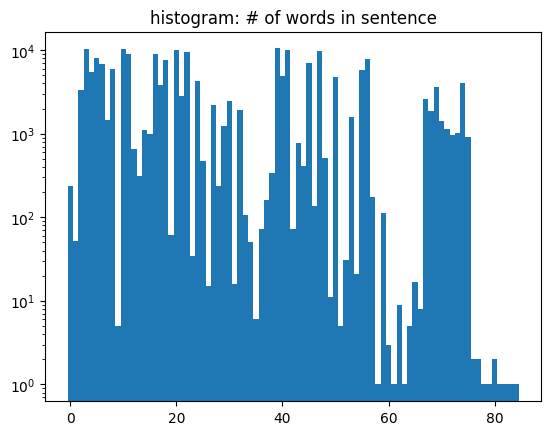

In [ ]:
from collections import Counter
c = Counter((len(t.split()) for t in flores_data['text']))
labels, values = zip(*c.items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.yscale('log')
plt.title('histogram: # of words in sentence')

Text(0.5, 1.0, 'histogram: # of texts per language')

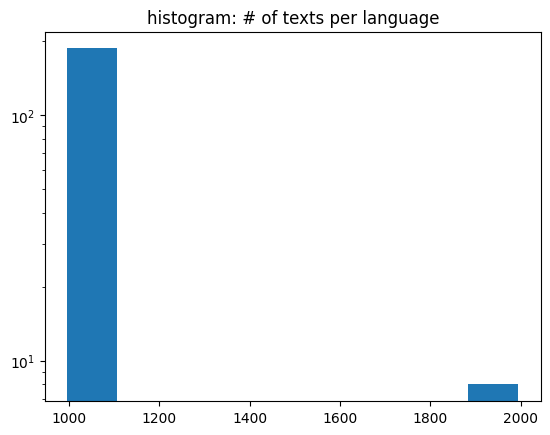

In [ ]:
plt.hist([len(df) for _,df in flores_data.groupby('language')], bins='auto')
plt.yscale('log')
plt.title('histogram: # of texts per language')

In [ ]:
uniq = np.unique(flores_data.language)
uniq, uniq.shape

(array(['ace', 'acm', 'acq', 'aeb', 'afr', 'aka', 'als', 'amh', 'apc',
        'arb', 'ars', 'ary', 'arz', 'asm', 'ast', 'awa', 'ayr', 'azb',
        'azj', 'bak', 'bam', 'ban', 'bel', 'bem', 'ben', 'bho', 'bjn',
        'bod', 'bos', 'bug', 'bul', 'cat', 'ceb', 'ces', 'cjk', 'ckb',
        'crh', 'cym', 'dan', 'deu', 'dik', 'dyu', 'dzo', 'ell', 'eng',
        'epo', 'est', 'eus', 'ewe', 'fao', 'fij', 'fin', 'fon', 'fra',
        'fur', 'fuv', 'gaz', 'gla', 'gle', 'glg', 'grn', 'guj', 'hat',
        'hau', 'heb', 'hin', 'hne', 'hrv', 'hun', 'hye', 'ibo', 'ilo',
        'ind', 'isl', 'ita', 'jav', 'jpn', 'kab', 'kac', 'kam', 'kan',
        'kas', 'kat', 'kaz', 'kbp', 'kea', 'khk', 'khm', 'kik', 'kin',
        'kir', 'kmb', 'kmr', 'knc', 'kon', 'kor', 'lao', 'lij', 'lim',
        'lin', 'lit', 'lmo', 'ltg', 'ltz', 'lua', 'lug', 'luo', 'lus',
        'lvs', 'mag', 'mai', 'mal', 'mar', 'min', 'mkd', 'mlt', 'mni',
        'mos', 'mri', 'mya', 'nld', 'nno', 'nob', 'npi', 'nso', 'nus',
      

# Final processing

## Add macro languages

In [ ]:
# add macro language
macros = [iso639.Language.from_part3(t).macrolanguage for t in flores_data['language']]
flores_data['language'] = [m if m is not None else l for m,l in zip(macros, flores_data['language'])]
# flores_data['is_macro'] = [True if m is not None else False for m in macros]


In [ ]:
# convert all the names to a more readable form
flores_data['language'] = [iso639.Language.from_part3(p).name for p in flores_data['language']]
# flores_data['macro'] = [iso639.Language.from_part3(p).name for p in flores_data['macro']]

In [ ]:
flores_data

,text,language
0,But shani hta Stanford dakkasu tsi dap kaw na ...,Kachin
1,Ndai arai hkyep gaw sinda mawng ana hpe sut su...,Kachin
2,"JAS 39C Gripen mying ai pyenli gaw, buga ginda...",Kachin
3,Dai nbungli gau ai wa hpe Squadron a ning baw ...,Kachin
4,"Buga shiga dap kaw na shapoi ai lam gaw, mahta...",Kachin
...,...,...
202386,हिल स्टेशन के लेल पर्यटन के मौसम आम तौर पर भार...,Magahi
202387,"हालांकि, सर्दी के दौरान ओकरा पास एगो अलग तरह क...",Magahi
202388,केवल कुछ एयरलाइंस अभीयो शोक किराया के पेशकश कर...,Magahi
202389,"एयरलाइंस जे एगोर पेश करई हई ओइमे एयर कनाडा, डे...",Magahi


In [ ]:
uniq = np.unique(flores_data.language)
uniq, uniq.shape

(array(['Achinese', 'Afrikaans', 'Akan', 'Albanian', 'Amharic', 'Arabic',
        'Armenian', 'Assamese', 'Asturian', 'Awadhi', 'Aymara',
        'Azerbaijani', 'Balinese', 'Bambara', 'Bashkir', 'Basque',
        'Belarusian', 'Bemba (Zambia)', 'Bengali', 'Bhojpuri', 'Buginese',
        'Bulgarian', 'Burmese', 'Catalan', 'Cebuano',
        'Central Atlas Tamazight', 'Chhattisgarhi', 'Chinese', 'Chokwe',
        'Crimean Tatar', 'Czech', 'Danish', 'Dinka', 'Dutch', 'Dyula',
        'Dzongkha', 'English', 'Esperanto', 'Estonian', 'Ewe', 'Faroese',
        'Fijian', 'Finnish', 'Fon', 'French', 'Friulian', 'Fulah',
        'Galician', 'Ganda', 'Georgian', 'German', 'Guarani', 'Gujarati',
        'Haitian', 'Hausa', 'Hebrew', 'Hindi', 'Hungarian', 'Icelandic',
        'Igbo', 'Iloko', 'Irish', 'Italian', 'Japanese', 'Javanese',
        'Kabiyè', 'Kabuverdianu', 'Kabyle', 'Kachin', 'Kamba (Kenya)',
        'Kannada', 'Kanuri', 'Kashmiri', 'Kazakh', 'Khmer', 'Kikuyu',
        'Kimbundu', 'Kin

In [ ]:
language_families = {
    'Achinese': 'Austronesian',
    'Afrikaans': 'Indo-European',
    'Akan': 'Niger-Congo',
    'Albanian': 'Indo-European',
    'Amharic': 'Afroasiatic',
    'Arabic': 'Afroasiatic',
    'Armenian': 'Indo-European',
    'Assamese': 'Indo-European',
    'Asturian': 'Indo-European',
    'Awadhi': 'Indo-European',
    'Aymara': 'Aymaran',
    'Azerbaijani': 'Turkic',
    'Balinese': 'Austronesian',
    'Bambara': 'Niger-Congo',
    'Bashkir': 'Turkic',
    'Basque': 'Language Isolate',
    'Belarusian': 'Indo-European',
    'Bemba (Zambia)': 'Niger-Congo',
    'Bengali': 'Indo-European',
    'Bhojpuri': 'Indo-European',
    'Buginese': 'Austronesian',
    'Bulgarian': 'Indo-European',
    'Burmese': 'Sino-Tibetan',
    'Catalan': 'Indo-European',
    'Cebuano': 'Austronesian',
    'Central Atlas Tamazight': 'Afroasiatic',
    'Chhattisgarhi': 'Indo-European',
    'Chinese': 'Sino-Tibetan',
    'Chokwe': 'Niger-Congo',
    'Crimean Tatar': 'Turkic',
    'Czech': 'Indo-European',
    'Danish': 'Indo-European',
    'Dinka': 'Nilo-Saharan',
    'Dutch': 'Indo-European',
    'Dyula': 'Niger-Congo',
    'Dzongkha': 'Sino-Tibetan',
    'English': 'Indo-European',
    'Esperanto': 'Constructed',
    'Estonian': 'Uralic',
    'Ewe': 'Niger-Congo',
    'Faroese': 'Indo-European',
    'Fijian': 'Austronesian',
    'Finnish': 'Uralic',
    'Fon': 'Niger-Congo',
    'French': 'Indo-European',
    'Friulian': 'Indo-European',
    'Fulah': 'Niger-Congo',
    'Galician': 'Indo-European',
    'Ganda': 'Niger-Congo',
    'Georgian': 'Kartvelian',
    'German': 'Indo-European',
    'Guarani': 'Tupian',
    'Gujarati': 'Indo-European',
    'Haitian': 'Indo-European',
    'Hausa': 'Afroasiatic',
    'Hebrew': 'Afroasiatic',
    'Hindi': 'Indo-European',
    'Hungarian': 'Uralic',
    'Icelandic': 'Indo-European',
    'Igbo': 'Niger-Congo',
    'Iloko': 'Austronesian',
    'Irish': 'Indo-European',
    'Italian': 'Indo-European',
    'Japanese': 'Japonic',
    'Javanese': 'Austronesian',
    'Kabiyè': 'Niger-Congo',
    'Kabuverdianu': 'Indo-European',
    'Kabyle': 'Afroasiatic',
    'Kachin': 'Sino-Tibetan',
    'Kamba (Kenya)': 'Niger-Congo',
    'Kannada': 'Dravidian',
    'Kanuri': 'Afroasiatic',
    'Kashmiri': 'Indo-European',
    'Kazakh': 'Turkic',
    'Khmer': 'Austroasiatic',
    'Kikuyu': 'Niger-Congo',
    'Kimbundu': 'Niger-Congo',
    'Kinyarwanda': 'Niger-Congo',
    'Kirghiz': 'Turkic',
    'Kongo': 'Niger-Congo',
    'Korean': 'Koreanic',
    'Kurdish': 'Indo-European',
    'Lao': 'Tai-Kadai',
    'Latvian': 'Indo-European',
    'Ligurian': 'Indo-European',
    'Limburgan': 'Indo-European',
    'Lingala': 'Niger-Congo',
    'Lithuanian': 'Indo-European',
    'Lombard': 'Indo-European',
    'Luba-Lulua': 'Niger-Congo',
    'Luo (Kenya and Tanzania)': 'Nilo-Saharan',
    'Lushai': 'Sino-Tibetan',
    'Luxembourgish': 'Indo-European',
    'Macedonian': 'Indo-European',
    'Magahi': 'Indo-European',
    'Maithili': 'Indo-European',
    'Malagasy': 'Austronesian',
    'Malay (macrolanguage)': 'Austronesian',
    'Malayalam': 'Dravidian',
    'Maltese': 'Afroasiatic',
    'Manipuri': 'Sino-Tibetan',
    'Maori': 'Austronesian',
    'Marathi': 'Indo-European',
    'Modern Greek (1453-)': 'Indo-European',
    'Mongolian': 'Mongolic',
    'Mossi': 'Niger-Congo',
    'Nepali (macrolanguage)': 'Indo-European',
    'Norwegian': 'Indo-European',
    'Nuer': 'Nilo-Saharan',
    'Nyanja': 'Niger-Congo',
    'Occitan (post 1500)': 'Indo-European',
    'Oriya (macrolanguage)': 'Indo-European',
    'Oromo': 'Afroasiatic',
    'Pangasinan': 'Austronesian',
    'Panjabi': 'Indo-European',
    'Papiamento': 'Creole',
    'Pedi': 'Niger-Congo',
    'Persian': 'Indo-European',
    'Polish': 'Indo-European',
    'Portuguese': 'Indo-European',
    'Pushto': 'Indo-European',
    'Quechua': 'Quechuan',
    'Romanian': 'Indo-European',
    'Rundi': 'Niger-Congo',
    'Russian': 'Indo-European',
    'Samoan': 'Austronesian',
    'Sango': 'Afroasiatic',
    'Sanskrit': 'Indo-European',
    'Santali': 'Austroasiatic',
    'Sardinian': 'Indo-European',
    'Scottish Gaelic': 'Indo-European',
    'Serbo-Croatian': 'Indo-European',
    'Shan': 'Tai-Kadai',
    'Shona': 'Niger-Congo',
    'Sicilian': 'Indo-European',
    'Silesian': 'Indo-European',
    'Sindhi': 'Indo-European',
    'Sinhala': 'Indo-European',
    'Slovak': 'Indo-European',
    'Slovenian': 'Indo-European',
    'Somali': 'Afroasiatic',
    'Southern Sotho': 'Niger-Congo',
    'Spanish': 'Indo-European',
    'Sundanese': 'Austronesian',
    'Swahili (macrolanguage)': 'Niger-Congo',
    'Swati': 'Niger-Congo',
    'Swedish': 'Indo-European',
    'Tagalog': 'Austronesian',
    'Tajik': 'Indo-European',
    'Tamashek': 'Afroasiatic',
    'Tamil': 'Dravidian',
    'Tatar': 'Turkic',
    'Telugu': 'Dravidian',
    'Thai': 'Tai-Kadai',
    'Tibetan': 'Sino-Tibetan',
    'Tigrinya': 'Afroasiatic',
    'Tok Pisin': 'Creole',
    'Tsonga': 'Niger-Congo',
    'Tswana': 'Niger-Congo',
    'Tumbuka': 'Niger-Congo',
    'Turkish': 'Turkic',
    'Turkmen': 'Turkic',
    'Uighur': 'Turkic',
    'Ukrainian': 'Indo-European',
    'Umbundu': 'Niger-Congo',
    'Urdu': 'Indo-European',
    'Uzbek': 'Turkic',
    'Venetian': 'Indo-European',
    'Vietnamese': 'Austroasiatic',
    'Waray (Philippines)': 'Austronesian',
    'Welsh': 'Indo-European',
    'Wolof': 'Niger-Congo',
    'Xhosa': 'Niger-Congo',
    'Yiddish': 'Indo-European',
    'Yoruba': 'Niger-Congo',
    'Zulu': 'Niger-Congo'
}


In [ ]:
for name, df in flores_data.groupby('language'):
  if not name in language_families:
    print(name)

In [ ]:
flores_data['macro'] = [language_families[n] for n in flores_data['language']]

In [ ]:
np.unique(flores_data.macro)

array(['Afroasiatic', 'Austroasiatic', 'Austronesian', 'Aymaran',
       'Constructed', 'Creole', 'Dravidian', 'Indo-European', 'Japonic',
       'Kartvelian', 'Koreanic', 'Language Isolate', 'Mongolic',
       'Niger-Congo', 'Nilo-Saharan', 'Quechuan', 'Sino-Tibetan',
       'Tai-Kadai', 'Tupian', 'Turkic', 'Uralic'], dtype=object)

# Dump to file

In [ ]:
flores_data

,text,language,macro
0,But shani hta Stanford dakkasu tsi dap kaw na ...,Kachin,Sino-Tibetan
1,Ndai arai hkyep gaw sinda mawng ana hpe sut su...,Kachin,Sino-Tibetan
2,"JAS 39C Gripen mying ai pyenli gaw, buga ginda...",Kachin,Sino-Tibetan
3,Dai nbungli gau ai wa hpe Squadron a ning baw ...,Kachin,Sino-Tibetan
4,"Buga shiga dap kaw na shapoi ai lam gaw, mahta...",Kachin,Sino-Tibetan
...,...,...,...
202386,हिल स्टेशन के लेल पर्यटन के मौसम आम तौर पर भार...,Magahi,Indo-European
202387,"हालांकि, सर्दी के दौरान ओकरा पास एगो अलग तरह क...",Magahi,Indo-European
202388,केवल कुछ एयरलाइंस अभीयो शोक किराया के पेशकश कर...,Magahi,Indo-European
202389,"एयरलाइंस जे एगोर पेश करई हई ओइमे एयर कनाडा, डे...",Magahi,Indo-European


In [ ]:
flores_data.to_feather('/content/drive/MyDrive/flores_dataset.feather')

In [ ]:
# data2 = pd.read_feather('/content/drive/MyDrive/final_dataset.feather')

## Try ML methods

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(flores_data.text.values, flores_data.language.values, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(flores_data.text.values, flores_data.macro.values, test_size=0.2, random_state=42)

# function to clean text
def clean_txt(text):
    text=text.lower()
    text=re.sub(r'[^\w\s]',' ',text)
    text=re.sub(r'[_0-9]',' ',text)
    text=re.sub(r'\s\s+',' ',text)
    return text

x_train = [clean_txt(text) for text in x_train]
x_test = [clean_txt(text) for text in x_test]

# using Tfidf Vectorizer:
tfidf = TfidfVectorizer()
tfidf.fit(x_train)
x_train_ready = tfidf.transform(x_train)
x_test_ready = tfidf.transform(x_test)

x_train_ready,x_test_ready

enc = LabelEncoder()
enc.fit(y_train)
y_train_ready = enc.transform(y_train)
y_test_ready = enc.transform(y_test)
# storing encoded label hast list as 'labels'
labels = enc.classes_
nb = MultinomialNB(fit_prior=False)
from sklearn.metrics import classification_report
# Fit the Multinomial Naive Bayes model
nb.fit(x_train_ready, y_train_ready)
# Make predictions on the test data
y_pred = nb.predict(x_test_ready)
# Reverse transform the encoded predictions to original labels
y_pred_original = enc.inverse_transform(y_pred)
# Generate a classification report
classification_rep = classification_report(y_test, y_pred_original, target_names=labels)
print(classification_rep)

                  precision    recall  f1-score   support

     Afroasiatic       0.88      0.99      0.93      4621
   Austroasiatic       1.00      1.00      1.00       608
    Austronesian       1.00      1.00      1.00      4101
         Aymaran       1.00      0.93      0.96       185
     Constructed       1.00      0.86      0.93       191
          Creole       1.00      0.85      0.92       426
       Dravidian       1.00      1.00      1.00       778
   Indo-European       0.98      1.00      0.99     15529
         Japonic       0.89      0.17      0.28       203
      Kartvelian       1.00      0.99      0.99       200
        Koreanic       1.00      0.96      0.98       199
Language Isolate       1.00      0.96      0.98       174
        Mongolic       0.99      1.00      1.00       190
     Niger-Congo       0.99      1.00      0.99      6934
    Nilo-Saharan       1.00      0.99      0.99       537
        Quechuan       1.00      0.94      0.97       212
    Sino-Tibe

In [ ]:
# use pipeline to combine prefitted vectorizer and trained model into one object
model = Pipeline([('vectorizer',tfidf),('nb',nb)])
# function to predict language from text
def predict(text):
    pred = model.predict([clean_txt(text)])
    ans = enc.inverse_transform(pred)
    return ans[0]
#       english                     hindi                     spanish?                        russian                   french
predict('my name is harsh'), predict('मेरा नाम हर्ष हे'), predict('mi nombre es harsh'), predict('меня зовут Харш'), predict('mon nom est harsh')

('Indo-European',
 'Indo-European',
 'Indo-European',
 'Indo-European',
 'Indo-European')

In [ ]:
#       zulu                    japanese                          chinese
predict('igama lami linzima'), predict('你好，我是一个喜欢了解一些不同主题的人'), predict('こんにちは、私はいくつかの異なるトピックについて学ぶのが好きな男です。 私は応用数学の学生で、どこまでもクールな男です。')


('Niger-Congo', 'Sino-Tibetan', 'Afroasiatic')

In [ ]:
for name, df in flores_data.groupby('macro'):
  # x_train, x_test, y_train, y_test = train_test_split(flores_data.text.values, flores_data.language.values, test_size=0.2, random_state=42)
  x_train, x_test, y_train, y_test = train_test_split(df.text.values, df.language.values, test_size=0.2, random_state=42)

  # function to clean text
  def clean_txt(text):
      text=text.lower()
      text=re.sub(r'[^\w\s]',' ',text)
      text=re.sub(r'[_0-9]',' ',text)
      text=re.sub(r'\s\s+',' ',text)
      return text

  x_train = [clean_txt(text) for text in x_train];
  x_test = [clean_txt(text) for text in x_test];

  # using Tfidf Vectorizer:
  tfidf = TfidfVectorizer()
  tfidf.fit(x_train)
  x_train_ready = tfidf.transform(x_train)
  x_test_ready = tfidf.transform(x_test)

  x_train_ready,x_test_ready

  enc = LabelEncoder()
  enc.fit(y_train)
  y_train_ready = enc.transform(y_train)
  y_test_ready = enc.transform(y_test)
  # storing encoded label hast list as 'labels'
  labels = enc.classes_
  nb = MultinomialNB()
  from sklearn.metrics import classification_report
  # Fit the Multinomial Naive Bayes model
  nb.fit(x_train_ready, y_train_ready)
  # Make predictions on the test data
  y_pred = nb.predict(x_test_ready)
  # Reverse transform the encoded predictions to original labels
  y_pred_original = enc.inverse_transform(y_pred)
  # Generate a classification report
  classification_rep = classification_report(y_test, y_pred_original, target_names=labels)
  print('#'*10)
  print(name)
  print('#'*10)
  print(classification_rep)
  print()

##########
Afroasiatic
##########
                         precision    recall  f1-score   support

                Amharic       1.00      0.93      0.96       200
                 Arabic       0.95      1.00      0.97      1831
Central Atlas Tamazight       1.00      0.97      0.99       190
                  Hausa       1.00      1.00      1.00       217
                 Hebrew       1.00      0.92      0.96       217
                 Kabyle       1.00      0.98      0.99       201
                 Kanuri       1.00      0.92      0.96       391
                Maltese       1.00      0.98      0.99       201
                  Oromo       1.00      0.98      0.99       198
                  Sango       1.00      1.00      1.00       214
                 Somali       1.00      1.00      1.00       174
               Tamashek       1.00      0.99      1.00       349
               Tigrinya       1.00      0.96      0.98       204

               accuracy                           0.98

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(flores_data.text.values, flores_data.language.values, test_size=0.2, random_state=42)

# function to clean text
def clean_txt(text):
    text=text.lower()
    text=re.sub(r'[^\w\s]',' ',text)
    text=re.sub(r'[_0-9]',' ',text)
    text=re.sub(r'\s\s+',' ',text)
    return text

x_train = [clean_txt(text) for text in x_train]
x_test = [clean_txt(text) for text in x_test]

# using Tfidf Vectorizer:
tfidf = TfidfVectorizer()
tfidf.fit(x_train)
x_train_ready = tfidf.transform(x_train)
x_test_ready = tfidf.transform(x_test)

x_train_ready,x_test_ready

enc = LabelEncoder()
enc.fit(y_train)
y_train_ready = enc.transform(y_train)
y_test_ready = enc.transform(y_test)
# storing encoded label hast list as 'labels'
labels = enc.classes_
nb = MultinomialNB(fit_prior=False)
from sklearn.metrics import classification_report
# Fit the Multinomial Naive Bayes model
nb.fit(x_train_ready, y_train_ready)
# Make predictions on the test data
y_pred = nb.predict(x_test_ready)
# Reverse transform the encoded predictions to original labels
y_pred_original = enc.inverse_transform(y_pred)
# Generate a classification report
classification_rep = classification_report(y_test, y_pred_original, target_names=labels)
print(classification_rep)

                          precision    recall  f1-score   support

                Achinese       0.37      1.00      0.54       376
               Afrikaans       0.99      0.99      0.99       192
                    Akan       0.97      1.00      0.98       416
                Albanian       1.00      1.00      1.00       190
                 Amharic       1.00      1.00      1.00       192
                  Arabic       0.99      1.00      0.99      1858
                Armenian       1.00      1.00      1.00       196
                Assamese       0.99      1.00      0.99       206
                Asturian       0.99      0.95      0.97       207
                  Awadhi       0.81      0.82      0.81       218
                  Aymara       1.00      0.98      0.99       185
             Azerbaijani       1.00      0.91      0.95       400
                Balinese       1.00      0.94      0.97       200
                 Bambara       0.95      0.93      0.94       195
         